In [33]:
import platform
print(f"platform.python_version(): {platform.python_version()}")

import os
import scipy
import numpy as np
from glob import glob
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

print(np.__version__)

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

import matplotlib.pyplot as plt

# 在windows用gpu跑tensorflow 最多只支持到2.10.1並且conda沒有2.10.1 只能用pip
# numpy和scipy也要配合安裝下列版本
# pip install tensorflow==2.10.1
# pip install numpy==1.20
# pip install scipy==1.7.3
print(f"np.version.version: {np.version.version}")
print(f"scipy.__version__: {scipy.__version__}")
print(f"tf.__version__: {tf.__version__}")
# 確認GPU是否可用
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

platform.python_version(): 3.9.13
1.22.4
np.version.version: 1.22.4
scipy.__version__: 1.7.3
tf.__version__: 2.10.1
tf.config.list_physical_devices('GPU'): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


取得訓練資料npy檔路徑放入 'npy_file_list'

In [34]:
npy_file_list = glob(f"{os.getcwd()}\\mfcc\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")
npy_file_list

type(npy_file_list): <class 'list'>
len(npy_file_list): 25523


['D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊也是一樣輸入email-4_shi4.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊也是一樣輸入email-7_shu.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊也是一樣輸入email-8_ru4.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊去執行這個app-1_zhe4.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊去執行這個app-4_zhi2.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊去執行這個app-5_xing2.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊去執行這個app-6_zhe4.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\android這邊去執行這個app-7_ge4.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\audi有極大機會在未來與sauber正式結盟-11_zheng4.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\audi有極大機會在未來與sauber正式結盟-13_jie2.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\audi有極大機會在未來與sauber正式結盟-14_meng2.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\\mfcc\\audi有極大機會在未來與sauber正式結盟-1_you3.npy',
 'D:\\Coding\\SchoolProject\\中文單音CNN分類\

將 'npy_file_list' 內所有npy檔轉成陣列並放入 'mfcc_list'

In [35]:
mfcc_list = []

for npy_file in tqdm(npy_file_list):
    mfcc = np.load(file=npy_file)
    mfcc_list.append(mfcc)

# 將list()轉換成np.array()
mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

# 不要印出 ipynb會爆炸
# mfcc_list

100%|██████████| 25523/25523 [00:04<00:00, 5949.26it/s]

type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (25523, 13, 44)


mfcc資料集標準化

In [36]:
scaler = StandardScaler()
# 因為標準器只能fit 2維的資料所以要將3維的mfcc資料集reshape成2維
# mfcc_data_nums: k
# mfcc_row: n
# mfcc_column: m
# (k, n, m) => (k * n, m)
scaler.fit(mfcc_list.reshape((mfcc_list.shape[0] * mfcc_list.shape[1], mfcc_list.shape[2])))

mfcc_list_scaled = []
for mfcc in mfcc_list:
    mfcc_list_scaled.append(scaler.transform(mfcc))

# 將list()轉換成np.array()
mfcc_list_scaled = np.array(mfcc_list_scaled)

print(f"type(mfcc_list_scaled): {type(mfcc_list_scaled)}")
print(f"mfcc_list_scaled.shape: {mfcc_list_scaled.shape}")

# 不要印出 ipynb會爆炸
# mfcc_scaled

type(mfcc_list_scaled): <class 'numpy.ndarray'>
mfcc_list_scaled.shape: (25523, 13, 44)


讀取 'npy_file_list' 中所有資料檔名的拼音標籤

In [37]:
label_pinyin_list = []

for npy_file in npy_file_list:
    label_pinyin = npy_file[npy_file.find("_") + 1:npy_file.find(".npy")]
    label_pinyin_list.append(label_pinyin)

# 將list()轉換成np.array()
label_pinyin_list = np.array(label_pinyin_list)

print(f"type(label_pinyin_list): {type(label_pinyin_list)}")
print(f"label_pinyin_list.shape: {label_pinyin_list.shape}")
label_pinyin_list

type(label_pinyin_list): <class 'numpy.ndarray'>
label_pinyin_list.shape: (25523,)


array(['shi4', 'shu', 'ru4', ..., 'dian3', 'kai', 'ta'], dtype='<U7')

dictionary 標籤轉換器<br>key => pinyin<br>value => int<br>(0 <= int <= 1466)

In [38]:
sample_list = glob(f"{os.getcwd()}\\samplePinyin\\Male\\*.wav")

label_dic: dict = {}
for i in range(len(sample_list)):
    label = sample_list[i][sample_list[i].find("_") + 1:sample_list[i].find(".wav")]
    label_dic[label] = i

print(f"type(label_dic): {type(label_dic)}")
print(f"len(label_dic): {len(label_dic)}")
label_dic

type(label_dic): <class 'dict'>
len(label_dic): 1467


{'a': 0,
 'a2': 1,
 'a4': 2,
 'a5': 3,
 'ai': 4,
 'ai2': 5,
 'ai3': 6,
 'ai4': 7,
 'an': 8,
 'an2': 9,
 'an3': 10,
 'an4': 11,
 'ang': 12,
 'ang2': 13,
 'ang3': 14,
 'ang4': 15,
 'ao': 16,
 'ao2': 17,
 'ao3': 18,
 'ao4': 19,
 'ba': 20,
 'ba2': 21,
 'ba3': 22,
 'ba4': 23,
 'ba5': 24,
 'bai': 25,
 'bai2': 26,
 'bai3': 27,
 'bai4': 28,
 'bai5': 29,
 'ban': 30,
 'ban3': 31,
 'ban4': 32,
 'bang': 33,
 'bang3': 34,
 'bang4': 35,
 'bao': 36,
 'bao2': 37,
 'bao3': 38,
 'bao4': 39,
 'bei': 40,
 'bei3': 41,
 'bei4': 42,
 'bei5': 43,
 'ben': 44,
 'ben3': 45,
 'ben4': 46,
 'beng': 47,
 'beng2': 48,
 'beng3': 49,
 'beng4': 50,
 'bi': 51,
 'bi2': 52,
 'bi3': 53,
 'bi4': 54,
 'bian': 55,
 'bian2': 56,
 'bian3': 57,
 'bian4': 58,
 'biao': 59,
 'biao3': 60,
 'biao4': 61,
 'bie': 62,
 'bie2': 63,
 'bie3': 64,
 'bie4': 65,
 'bin': 66,
 'bin3': 67,
 'bin4': 68,
 'bing': 69,
 'bing3': 70,
 'bing4': 71,
 'bo': 72,
 'bo2': 73,
 'bo3': 74,
 'bo4': 75,
 'bo5': 76,
 'bu': 77,
 'bu2': 78,
 'bu3': 79,
 'bu4': 80,

將 'label_pinyin_list' 裡的拼音標籤轉換成數字標籤放入 'label_int_list'

In [39]:
label_int_list = []
for label_pinyin in label_pinyin_list:
    label_int = label_dic[label_pinyin]
    label_int_list.append(label_int)

label_int_list = np.array(label_int_list)
print(f"label_int_list.shape => {label_int_list.shape}")
label_int_list

label_int_list.shape => (25523,)


array([1064, 1070,  992, ...,  243,  529, 1122])

定義CNN模型

In [40]:
def get_cnn_model(input_shape, num_classes, learning_rate=0.001, num_filters=32, dense_units=256):
    cnn_model = Sequential()

    # 第一層捲積層
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 第二層捲積層
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 第三層捲積層
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 展平
    cnn_model.add(Flatten())
    
    # 第一層全連接層
    cnn_model.add(Dense(dense_units))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    
    # 第二層全連接層
    cnn_model.add(Dense(dense_units * 2))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    
    # 第三層全連接層(長度同為1467個label)
    cnn_model.add(Dense(num_classes))
    
    # 表示為機率
    cnn_model.add(Activation('softmax'))

    cnn_model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return cnn_model

參數設定

In [41]:
channel = 1
verbose = 2
epochs = 100
batch_size = 32
num_classes = len(label_dic)
test_size = 0.2
mfcc_dim_1 = mfcc_list.shape[1]
mfcc_dim_2 = mfcc_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


資料分割

In [42]:
X = mfcc_list_scaled
y = label_int_list

# 將int label轉換成二進制one hot標籤
y_one_hot = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=test_size, random_state=42)

X_train = X_train.reshape(X_train.shape[0], mfcc_dim_1, mfcc_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], mfcc_dim_1, mfcc_dim_2, channel)

訓練模型

In [43]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/100
639/639 - 5s - loss: 5.0990 - accuracy: 0.1186 - val_loss: 4.4744 - val_accuracy: 0.1573 - 5s/epoch - 7ms/step
Epoch 2/100
639/639 - 4s - loss: 3.8480 - accuracy: 0.2097 - val_loss: 4.0654 - val_accuracy: 0.2024 - 4s/epoch - 6ms/step
Epoch 3/100
639/639 - 4s - loss: 3.3229 - accuracy: 0.2716 - val_loss: 3.5472 - val_accuracy: 0.2588 - 4s/epoch - 6ms/step
Epoch 4/100


KeyboardInterrupt: 

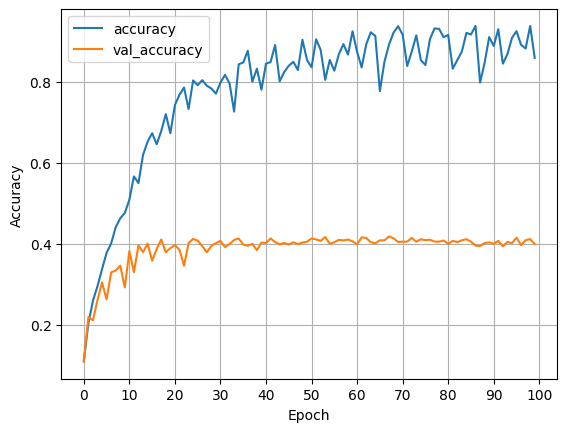

In [30]:
accuracies = model_train_info.history['accuracy']
val_accuracies = model_train_info.history['val_accuracy']

plt.plot(list(range(epochs)), accuracies, label = 'accuracy')
plt.plot(list(range(epochs)), val_accuracies, label = 'val_accuracy')
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, epochs + 1, 10)))
plt.show()

準確度

In [31]:
print(f"資料: {mfcc_list_scaled.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (25523, 13, 44)
最高準確率: 0.41821742057800293


In [32]:
model.save(f"{os.getcwd()}\\cnn_model.h5")